## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [9]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Data Load

In [10]:
# 데이터 로드
IVF_train = pd.read_csv('../data/IVF_train_dataset_26.csv')
IVF_test = pd.read_csv('../data/IVF_test_dataset_26.csv')

DI_train = pd.read_csv('../data/DI_train_dataset_26.csv')
DI_test = pd.read_csv('../data/DI_test_dataset_26.csv')

In [11]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X = IVF_train.drop(['임신_성공_여부', 'ID'], axis=1)
IVF_y = IVF_train['임신_성공_여부']

DI_X = DI_train.drop(['임신_성공_여부', 'ID'], axis=1)
DI_y = DI_train['임신_성공_여부']

In [12]:
print(f"IVF_X shape: {IVF_X.shape}")
print(f"IVF_test shape: {IVF_test.drop('ID', axis=1).shape}")
print(f"DI_X shape: {DI_X.shape}")
print(f"DI_test shape: {DI_test.drop('ID', axis=1).shape}")

IVF_X shape: (250052, 77)
IVF_test shape: (87891, 77)
DI_X shape: (6289, 31)
DI_test shape: (2176, 31)


### 인코딩 

In [13]:
IVF_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "특정_시술_유형",
    "배란_유도_유형",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "채취_해동_차이",
    "해동_혼합_차이",
    "혼합_이식_차이",
    "이식_해동_차이"
]

In [14]:
DI_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "특정_시술_유형",
    "정자_기증자_나이"
]

In [15]:
# 모든 범주형 변수를 문자열로 변환
IVF_X[IVF_categorical_columns] = IVF_X[IVF_categorical_columns].astype(str)
DI_X[DI_categorical_columns] = DI_X[DI_categorical_columns].astype(str)
IVF_test[IVF_categorical_columns] = IVF_test[IVF_categorical_columns].astype(str)
DI_test[DI_categorical_columns] = DI_test[DI_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
IVF_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
DI_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

IVF_X[IVF_categorical_columns] = IVF_encoder.fit_transform(IVF_X[IVF_categorical_columns])
DI_X[DI_categorical_columns] = DI_encoder.fit_transform(DI_X[DI_categorical_columns])
IVF_test[IVF_categorical_columns] = IVF_encoder.transform(IVF_test[IVF_categorical_columns])
DI_test[DI_categorical_columns] = DI_encoder.transform(DI_test[DI_categorical_columns])

## Modeling

In [16]:
# 데이터 분할
IVF_X_train, IVF_X_test, IVF_y_train, IVF_y_test = train_test_split(IVF_X, IVF_y, test_size=0.2, random_state=42)
DI_X_train, DI_X_test, DI_y_train, DI_y_test = train_test_split(DI_X, DI_y, test_size=0.2, random_state=42)

In [ ]:
# !pip install mljar-supervised

In [ ]:
X_train = IVF_X_train
X_test = IVF_X_test
y_train = IVF_y_train
y_test = IVF_y_test

In [23]:
from supervised.automl import AutoML
from sklearn.metrics import roc_auc_score

#  특징(X)와 타겟(y) 분리
automl = AutoML(
    mode="Compete",
    total_time_limit=7200,
    eval_metric="auc",  # 평가 기준을 ROC-AUC로 설정
    golden_features=True,  # 중요한 피처 생성
    kmeans_features=True,  # K-means 기반 피처 생성
    mix_encoding=True,  # 다양한 인코딩 적용
    algorithms=["CatBoost", "LightGBM", "Xgboost"],  
)

automl.fit(X_train, y_train)

# 검증 (Validation Set으로 성능 확인)
val_preds = automl.predict_proba(X_test)[:, 1]  # 확률값 예측
val_auc = roc_auc_score(y_test, val_preds)  # ROC-AUC 계산

print(f"\n검증 데이터 ROC-AUC: {val_auc:.4f}")

AutoML directory: AutoML_1
The task is binary_classification with evaluation metric auc
AutoML will use algorithms: ['CatBoost', 'LightGBM', 'Xgboost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree auc 0.695886 trained in 3.04 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle,Stratify
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models
1_Default_LightGBM auc 0.736394 trained in 52.99 seconds
2_Default_Xgboost auc 0.737013 trained in 99.89 seconds
3_Default_CatBoost auc 0.737543 trained in 86.02 seconds
* Step not_so_ra

In [28]:
# ID 열을 제외한 특성과 타겟 변수 분리
IVF_X_test = IVF_test.drop(['ID'], axis=1)


In [29]:
# 📌 예측 수행
preds = automl.predict_proba(IVF_X_test)[:, 1]

# 📌 결과 저장
submission = pd.DataFrame({"ID": IVF_test['ID'], "probability": preds})
submission.to_csv("submission_AutoML_IVF.csv", index=False, encoding="utf-8-sig")

print("\n✅ [결과 저장 완료] 파일: submission_AutoML_IVF.csv")


✅ [결과 저장 완료] 파일: submission_AutoML_IVF.csv


In [30]:
X_train = DI_X_train
X_test = DI_X_test
y_train = DI_y_train
y_test = DI_y_test

AutoML directory: AutoML_2
The task is binary_classification with evaluation metric auc
AutoML will use algorithms: ['CatBoost', 'LightGBM', 'Xgboost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree auc 0.675223 trained in 3.19 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle,Stratify
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models
1_Default_LightGBM auc 0.654829 trained in 19.66 seconds
2_Default_Xgboost auc 0.561741 trained in 14.94 seconds
3_Default_CatBoost auc 0.668856 trained in 17.23 seconds
* Step not_so_ra

KeyboardInterrupt: 

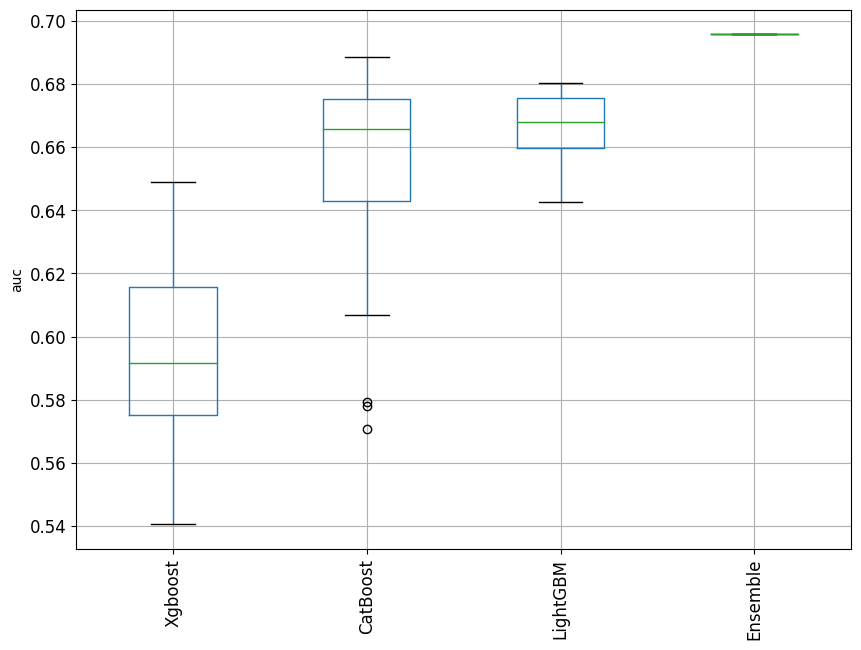

In [31]:
from supervised.automl import AutoML
from sklearn.metrics import roc_auc_score

#  특징(X)와 타겟(y) 분리
automl = AutoML(
    mode="Compete",
    total_time_limit=7200,
    eval_metric="auc",  # 평가 기준을 ROC-AUC로 설정
    golden_features=True,  # 중요한 피처 생성
    kmeans_features=True,  # K-means 기반 피처 생성
    mix_encoding=True,  # 다양한 인코딩 적용
    algorithms=["CatBoost", "LightGBM", "Xgboost"],  
    random_state=42
)

automl.fit(X_train, y_train)

# 검증 (Validation Set으로 성능 확인)
val_preds = automl.predict_proba(X_test)[:, 1]  # 확률값 예측
val_auc = roc_auc_score(y_test, val_preds)  # ROC-AUC 계산

print(f"\n검증 데이터 ROC-AUC: {val_auc:.4f}")

In [ ]:
# ID 열을 제외한 특성과 타겟 변수 분리
DI_X_test = DI_test.drop(['ID'], axis=1)

In [ ]:
# 📌 예측 수행
preds = automl.predict_proba(DI_X_test)[:, 1]

# 📌 결과 저장
submission = pd.DataFrame({"ID": DI_test['ID'], "probability": preds})
submission.to_csv("submission_AutoML_DI.csv", index=False, encoding="utf-8-sig")

print("\n✅ [결과 저장 완료] 파일: submission_AutoML_DI.csv")

### IVF 데이터


--- Model Performance ---
Model Accuracy: 0.7454759952810381
Model F1 Score: 0.19655368301458057
Model AUC: 0.7402165540043341


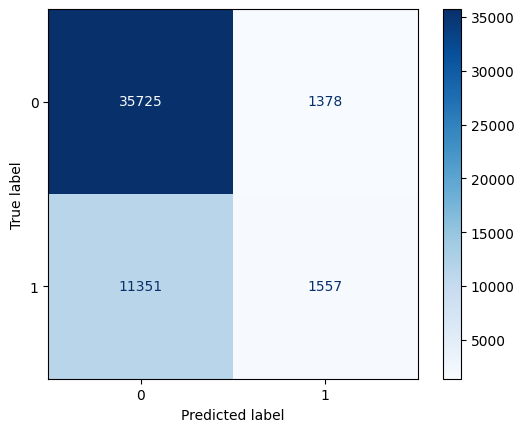

In [24]:
# 모델 초기화
IVF_model = lgb.LGBMClassifier(
    n_estimators=4471,
    num_leaves=13,
    max_depth=279,
    learning_rate=0.007075124517450591,
    min_child_samples=26,
    subsample=0.29772991936701476,
    colsample_bytree=0.8913054521763838,
    reg_alpha=0.0004860363321690653,
    reg_lambda=311.08056657247363,
    min_split_gain=0.18214905183450955,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
IVF_model.fit(IVF_X_train, IVF_y_train)

# 예측
y_pred = IVF_model.predict(IVF_X_test)
y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

# 평가
accuracy = accuracy_score(IVF_y_test, y_pred)
f1 = f1_score(IVF_y_test, y_pred)
auc = roc_auc_score(IVF_y_test, y_pred_proba)
cm = confusion_matrix(IVF_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### DI 데이터


--- Model Performance ---
Model Accuracy: 0.8736089030206677
Model F1 Score: 0.0
Model AUC: 0.7044482977664086


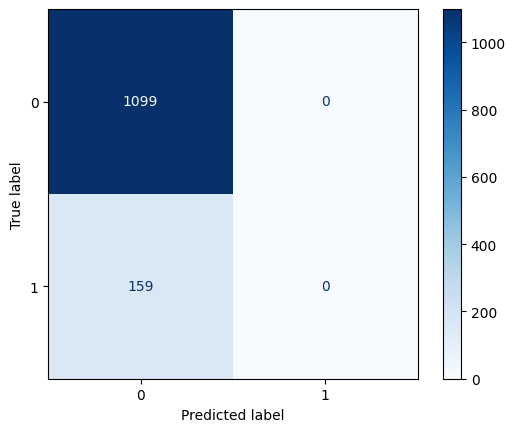

In [25]:
# 모델 초기화
DI_model = lgb.LGBMClassifier(
    n_estimators=1816,
    num_leaves=3926,
    max_depth=259,
    learning_rate=0.00238377640011148,
    min_child_samples=1,
    subsample=0.7610056627240331,
    colsample_bytree=0.6655579164853634,
    reg_alpha=0.00025227758337188327,
    reg_lambda=76.744107215122684,
    min_split_gain=0.007773520329665474,
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

# 모델 학습
DI_model.fit(DI_X_train, DI_y_train)

# 예측
y_pred = DI_model.predict(DI_X_test)
y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 평가
accuracy = accuracy_score(DI_y_test, y_pred)
f1 = f1_score(DI_y_test, y_pred)
auc = roc_auc_score(DI_y_test, y_pred_proba)
cm = confusion_matrix(DI_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DI_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


--- Model Performance ---
Model Accuracy: 0.7486200237960561
Model F1 Score: 0.1946006749156355
Model AUC: 0.742143990094072


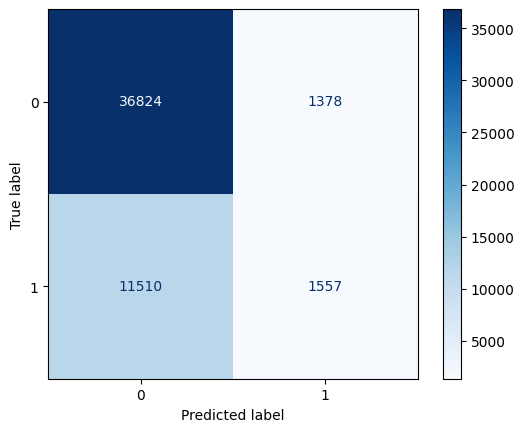

In [26]:
# 예측
IVF_y_pred = IVF_model.predict(IVF_X_test)
IVF_y_pred_proba = IVF_model.predict_proba(IVF_X_test)[:, 1]

DI_y_pred = DI_model.predict(DI_X_test)
DI_y_pred_proba = DI_model.predict_proba(DI_X_test)[:, 1]

# 예측 결과 병합
y_test = pd.concat([IVF_y_test, DI_y_test])
y_pred = pd.concat([pd.Series(IVF_y_pred, index=IVF_y_test.index), pd.Series(DI_y_pred, index=DI_y_test.index)])
y_pred_proba = pd.concat([pd.Series(IVF_y_pred_proba, index=IVF_y_test.index), pd.Series(DI_y_pred_proba, index=DI_y_test.index)])

# 평가
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=IVF_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

데이콘 PUBLIC 0.7418619172

## 제출

In [28]:
# 모델 학습 및 예측
IVF_model.fit(IVF_X, IVF_y)
IVF_pred_proba = IVF_model.predict_proba(IVF_test.drop('ID', axis=1))[:, 1]

DI_model.fit(DI_X, DI_y)
DI_pred_proba = DI_model.predict_proba(DI_test.drop('ID', axis=1))[:, 1]

In [29]:
# 예측 결과 병합
IVF_test['probability'] = IVF_pred_proba
DI_test['probability'] = DI_pred_proba

# 최종 제출 파일 생성
submission = pd.concat([IVF_test[['ID', 'probability']], DI_test[['ID', 'probability']]], axis=0)
submission = submission.sort_values(by='ID')  

# 제출 파일 저장
submission.to_csv('../submission/code26_submit.csv', index=False, encoding='utf-8')

---

In [4]:
import pandas as pd

# 두 CSV 파일을 읽어옵니다.
df1 = pd.read_csv('../submission/code26_submit.csv')
df2 = pd.read_csv('../submission/code26_submit_xgb.csv')

# ID를 기준으로 병합합니다.
merged_df = pd.merge(df1, df2, on='ID', suffixes=('_df1', '_df2'))

# 'probability' 열을 소프트 보팅하여 새로운 'probability' 열 생성
merged_df['probability'] = (merged_df['probability_df1'] + merged_df['probability_df2']) / 2

# 최종 제출 파일 생성
submission = merged_df[['ID', 'probability']]
submission = submission.sort_values(by='ID')

# 제출 파일 저장
submission.to_csv('../submission/code26_soft_voting_submit_LgbmXgb.csv', index=False, encoding='utf-8')

데이콘 PUBLIC 0.741867513	

In [6]:
import pandas as pd

# 두 CSV 파일을 읽어옵니다.
df1 = pd.read_csv('../submission/code26_submit.csv')
df2 = pd.read_csv('../submission/code26_submit_xgb.csv')

# ID를 기준으로 병합합니다.
merged_df = pd.merge(df1, df2, on='ID', suffixes=('_df1', '_df2'))

# 'probability' 열을 조건에 따라 선택하여 새로운 'probability' 열 생성
def select_probability(row):
    if row['probability_df1'] > 0.35 and row['probability_df2'] > 0.35:
        return max(row['probability_df1'], row['probability_df2'])
    elif row['probability_df1'] < 0.25 and row['probability_df2'] < 0.25:
        return min(row['probability_df1'], row['probability_df2'])
    else:
        return row['probability_df1']

merged_df['probability'] = merged_df.apply(select_probability, axis=1)

# 최종 제출 파일 생성
submission = merged_df[['ID', 'probability']]
submission = submission.sort_values(by='ID')

# 제출 파일 저장
submission.to_csv('../submission/code26_voting_upgrad_submit_LgbmXgb.csv', index=False, encoding='utf-8')

데이콘 PUBLIC 0.7419275123

In [5]:
import pandas as pd

# 세 CSV 파일을 읽어옵니다.
df1 = pd.read_csv('../submission/code26_submit.csv')
df2 = pd.read_csv('../submission/code26_submit_xgb.csv')
df3 = pd.read_csv('../submission/code26_submit_cat.csv')

# ID를 기준으로 병합합니다.
merged_df = pd.merge(df1, df2, on='ID', suffixes=('_df1', '_df2'))
merged_df = pd.merge(merged_df, df3, on='ID')

# 'probability' 열을 소프트 보팅하여 새로운 'probability' 열 생성
merged_df['probability'] = (merged_df['probability_df1'] + merged_df['probability_df2'] + merged_df['probability']) / 3

# 최종 제출 파일 생성
submission = merged_df[['ID', 'probability']]
submission = submission.sort_values(by='ID')

# 제출 파일 저장
submission.to_csv('../submission/code26_soft_voting_submit_LgbmXgbCat.csv', index=False, encoding='utf-8')

데이콘 PUBLIC 0.740968999

In [1]:
import pandas as pd

# 세 CSV 파일을 읽어옵니다.
df1 = pd.read_csv('../submission/code26_submit.csv')
df2 = pd.read_csv('../submission/code26_submit_xgb.csv')
df3 = pd.read_csv('../submission/code28_submit.csv')

# ID를 기준으로 병합합니다.
merged_df = pd.merge(df1, df2, on='ID', suffixes=('_df1', '_df2'))
merged_df = pd.merge(merged_df, df3, on='ID')

# 'probability' 열을 조건에 따라 선택하여 새로운 'probability' 열 생성
def select_probability(row):
    if row['probability_df1'] > 0.35 and row['probability_df2'] > 0.35:
        if row['probability'] > 0.35:
            return max(row['probability_df1'], row['probability_df2'], row['probability'])
        else:
            return max(row['probability_df1'], row['probability_df2'])
    elif row['probability_df1'] < 0.25 and row['probability_df2'] < 0.25:
        if row['probability'] < 0.25:
            return min(row['probability_df1'], row['probability_df2'], row['probability'])
        else:
            return min(row['probability_df1'], row['probability_df2'])
    else:
        return row['probability_df1']

merged_df['probability'] = merged_df.apply(select_probability, axis=1)

# 최종 제출 파일 생성
submission = merged_df[['ID', 'probability']]
submission = submission.sort_values(by='ID')

# 제출 파일 저장
submission.to_csv('../submission/code28_voting_upgrad_submit.csv', index=False, encoding='utf-8')

In [1]:
import pandas as pd

# 세 CSV 파일을 읽어옵니다.
df1 = pd.read_csv('../submission/code26_submit.csv')
df2 = pd.read_csv('../submission/code26_submit_xgb.csv')
df3 = pd.read_csv('../submission/code26_submit_cat.csv')

# ID를 기준으로 병합합니다.
merged_df = pd.merge(df1, df2, on='ID', suffixes=('_df1', '_df2'))
merged_df = pd.merge(merged_df, df3, on='ID')

# 'probability' 열을 조건에 따라 선택하여 새로운 'probability' 열 생성
def select_probability(row):
    if row['probability_df1'] > 0.35 and row['probability_df2'] > 0.35:
        if row['probability'] > 0.35:
            return max(row['probability_df1'], row['probability_df2'], row['probability'])
        else:
            return max(row['probability_df1'], row['probability_df2'])
    elif row['probability_df1'] < 0.25 and row['probability_df2'] < 0.25:
        if row['probability'] < 0.25:
            return min(row['probability_df1'], row['probability_df2'], row['probability'])
        else:
            return min(row['probability_df1'], row['probability_df2'])
    else:
        return row['probability_df1']

merged_df['probability'] = merged_df.apply(select_probability, axis=1)

# 최종 제출 파일 생성
submission = merged_df[['ID', 'probability']]
submission = submission.sort_values(by='ID')

# 제출 파일 저장
submission.to_csv('../submission/code26_voting_upgrad_submit_LgbmXgbCat.csv', index=False, encoding='utf-8')

데이콘 PUBLIC 0.7404372168

In [5]:
import pandas as pd

# 두 CSV 파일을 읽어옵니다.
df1 = pd.read_csv('../submission/code26_voting_upgrad_submit_LgbmXgb.csv')
df2 = pd.read_csv('../submission/code26_voting_upgrad_submit_LgbmXgbCat.csv')

# ID를 기준으로 병합하여 값이 다른 행을 찾습니다.
merged_df = pd.merge(df1, df2, on='ID', suffixes=('_df1', '_df2'))

# 'probability' 열의 값이 다른 행을 필터링합니다.
different_rows = merged_df[merged_df['probability_df1'] != merged_df['probability_df2']]

In [9]:
different_rows.tail(3)

,ID,probability_df1,probability_df2
90063,TEST_90063,0.300819,0.306604
90064,TEST_90064,0.520521,0.524196
90066,TEST_90066,0.001120,0.001123


.